In [72]:
# Import the Earth Engine Python Package
import ee

# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize()

elev = ee.Image("USGS/SRTMGL1_003");
gridmet = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET");
l4sr = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR");
l5sr = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR");
l7sr = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR");
l8sr = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR");

mixed_conifer = ee.Image("users/mkoontz/mixed_conifer");
sn = ee.FeatureCollection("users/mkoontz/SierraEcoregion_Jepson");
fire17_1_sn_ypmc = ee.FeatureCollection("users/mkoontz/fire17_1_sn_ypmc");

In [73]:
# This function appends a 'tag' string to a list (for instance band names) and returns a new list
# Example use is adding "_post" after all default bandnames for a post fire image

def paste(list1, tag):
    return list1.map(lambda x: ee.String(x).cat(ee.String('_')).cat(ee.String(tag)))


In [74]:
def mask_cloud_water_snow(resample_method):
    def mask_cloud_water_snow_internal(img):
        # Use the "closure in JavaScript technique to pass arguments to a mapped function
        # mentioned here: https://groups.google.com/d/msg/google-earth-engine-developers/jB342iaPeX4/KXJYReksDQAJ
        # demonstrated here: https://code.earthengine.google.com/80b35b7e358e94664dc6107e75a4a43a
        # Each pixel gets a 1 if it is NOT a cloud, and a 0 if it IS a cloud
        cloudMask = img.select('pixel_qa').bitwiseAnd(32).eq(0);
        # Each pixel gets a 1 if it is NOT a cloud shadow, and a 0 if it IS a cloud shadow
        cloudShadowMask = img.select('pixel_qa').bitwiseAnd(8).eq(0);
        # Each pixel gets a 1 if it is NOT water, and a 0 if it IS water
        waterMask = img.select('pixel_qa').bitwiseAnd(4).eq(0);
        # Each pixel gets a 1 if it is NOT snow, and a 0 if it IS snow
        snowMask = img.select('pixel_qa').bitwiseAnd(16).eq(0);

        # For the combined mask (1 is a pixel we want to keep, and a 0 is one we want to mask),
        # the pixel must both NOT be a cloud AND NOT be a cloud shadow AND NOT be water 
        # AND NOT be snow(a 1 for all of the above masks) in order to be a valid pixel.
        # mask = cloudMask.and(cloudShadowMask).and(waterMask).and(snowMask);
        mask = cloudMask.add(cloudShadowMask).add(waterMask).add(snowMask);
        mask = mask.eq(4);

        # Return an interpolated image with all cloud and cloud shadow pixels masked.
        # Use interpolation because CBI on-the-ground plots are unlikely to
        # lie exactly at the center of a pixel. See Cansler MSc thesis (2011)
        # and Parks et al. (2014)

        # Interpolate (resample) for on-the-ground data (cbi plot) validation
        # Don't interpolate for analyses with only remote-sensed variables

        export_img = ee.Algorithms.If(resample_method == 'none',
                                            img.updateMask(mask),
                                            img.resample(resample_method).updateMask(mask));     

        return export_img;
    return mask_cloud_water_snow_internal;

In [75]:
def rename_l8(image):
    return image.rename(['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa']).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa']);


In [76]:
def merge_collections(start, end, bounds, sats):
# As of 2018-01-24, data are available between 
#  August 22, 1982 and December 14, 1993
# https://explorer.earthengine.google.com/#detail/LANDSAT%2FLT04%2FC01%2FT1_SR
# l4 is the Landsat 4 SR product filtered around the feature's 
# alarm date IF Landsat 4 is part of the desired final product
# If not, a blank image collection will be returned
   
    if '4' in sats:
        l4 = l4sr.filterDate(start, end).filterBounds(bounds).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'])
    if '4' not in sats: 
        l4 = ee.ImageCollection([]);
  
  # As of 2018-01-24, data are available between 
  #  January 1, 1984 to May 5, 2012
  # https://explorer.earthengine.google.com/#detail/LANDSAT%2FLT05%2FC01%2FT1_SR
  # l5 is the Landsat 5 SR product filtered around the feature's 
  # alarm date IF Landsat 5 is part of the desired final product
  # If not, a blank image collection will be returned
    if '5' in sats:
        l5 = l5sr.filterDate(start, end).filterBounds(bounds).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'])
    if '5' not in sats: 
        l5 = ee.ImageCollection([]);
        
  # As of 2018-01-24, data are available between 
  #  January 1, 1999 and December 21, 2017
  # https://explorer.earthengine.google.com/#detail/LANDSAT%2FLE07%2FC01%2FT1_SR
  # l7 is the Landsat 7 SR product filtered around the feature's 
  # alarm date IF Landsat 7 is part of the desired final product
  # If not, a blank image collection will be returned
  
  # Original band names
  # Name	Scale Factor	Description
  # B1	0.0001	Band 1 (blue) surface reflectance, 0.45-0.52 μm
  # B2	0.0001	Band 2 (green) surface reflectance, 0.52-0.60 μm
  # B3	0.0001	Band 3 (red) surface reflectance, 0.63-0.69 μm
  # B4	0.0001	Band 4 (near infrared) surface reflectance, 0.77-0.90 μm
  # B5	0.0001	Band 5 (shortwave infrared 1) surface reflectance, 1.55-1.75 μm
  # B6	0.1	Band 6 brightness temperature (Kelvin), 10.40-12.50 μm
  # B7	0.0001	Band 7 (shortwave infrared 2) surface reflectance, 2.08-2.35 μm
  # sr_atmos_opacity	0.001	Atmospheric opacity; < 0.1 = clear; 0.1 - 0.3 = average; > 0.3 = hazy
  # sr_cloud_qa		Cloud quality attributes, see SR Cloud QA table. Note: pixel_qa is likely to present more accurate results than sr_cloud_qa for cloud masking. See page 23 in the LEDAPS product guide.
  # pixel_qa		Pixel quality attributes generated from the CFMASK algorithm, see Pixel QA table
  # radsat_qa		Radiometric saturation QA, see Radiometric Saturation QA table

    if '7' in sats:
        l7 = l7sr.filterDate(start, end).filterBounds(bounds).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'])
    if '7' not in sats: 
        l7 = ee.ImageCollection([]);
  
  # As of 2018-01-24, data are available between 
  #  April 11, 2013 and January 3, 2018
  # https://explorer.earthengine.google.com/#detail/LANDSAT%2FLC08%2FC01%2FT1_SR
  # l8 is the Landsat 8 SR product filtered around the feature's 
  # alarm date IF Landsat 8 is part of the desired final product
  # If not, a blank image collection will be returned
  
  # Original band names
  # Name	Scale Factor	Description
  # B1	0.0001	Band 1 (Ultra Blue) surface reflectance, 0.435-0.451 μm
  # B2	0.0001	Band 2 (Blue) surface reflectance, 0.452-0.512 μm
  # B3	0.0001	Band 3 (Green) surface reflectance, 0.533-0.590 μm
  # B4	0.0001	Band 4 (Red) surface reflectance, 0.636-0.673 μm
  # B5	0.0001	Band 5 (Near Infrared) surface reflectance, 0.851-0.879 μm
  # B6	0.0001	Band 6 (Shortwave Infrared 1) surface reflectance, 1.566-1.651 μm
  # B7	0.0001	Band 7 (Shortwave Infrared 2) surface reflectance, 2.107-2.294 μm
  # B10	0.1	Band 10 brightness temperature (Kelvin), 10.60-11.19 μm
  # B11	0.1	Band 11 brightness temperature (Kelvin), 11.50-12.51 μm
  # sr_aerosol		Aerosol attributes, see Aerosol QA table
  # pixel_qa		Pixel quality attributes, see Pixel QA table
  # radsat_qa		Radiometric saturation QA, see Radsat QA table

    if '8' in sats:
        l8 = l8sr.filterDate(start, end).filterBounds(bounds).map(rename_l8);
    if '8' not in sats: 
        l8 = ee.ImageCollection([]);

    raw = l4.merge(l5).merge(l7).merge(l8);
    
    return(raw);  

In [77]:
def get_preFireRaw(feature, timeWindow, resample_method, sats):
    fireDate = ee.Date(feature.get('alarm_date'));
    firePerim = feature.geometry();

  # Prefire image collection derivecd by gathering all images "timeWindow"
  # (a global variable) days before the fire. 
  # These variables define the time period to grab those images. 
    preend = fireDate.advance(-1, 'day');
    prestart = preend.advance(timeWindow * -1, 'day');
  
    preFireCollection = merge_collections(prestart, preend, firePerim, sats);
    
  # We apply the cloud mask over each of those images
    preFire = preFireCollection.map(mask_cloud_water_snow(resample_method));
    
  # Return the preFire image collection
    return preFire;

In [78]:
#  get_postFireRaw() returns a post fire raw image collection. This time we look 1 year after the 
#  prefire image collection.
def get_postFireRaw(feature, timeWindow, resample_method, sats):
    fireDate = ee.Date(feature.get('alarm_date'));
    firePerim = feature.geometry();
  
    # Need to get pre fire reference date in order to advance to 1 year later
    preend = fireDate.advance(-1, 'day');
    prestart = preend.advance(timeWindow * -1, 'day');
  
    # Post fire image comes from median of images exactly 1 year after pre-fire images
    poststart = prestart.advance(1, 'year');
    postend = preend.advance(1, 'year');
  
    postFireCollection = merge_collections(poststart, postend, firePerim, sats);

    # We apply the cloud mask over each of those images
    postFire = postFireCollection.map(mask_cloud_water_snow(resample_method));

    return ee.ImageCollection(postFire);

In [79]:
#  This function returns the median values for pre fire bands 1 through 7
def get_preFireRaw_median(feature, timeWindow, resample_method, sats):
  
    preFraw_median = get_preFireRaw(feature, timeWindow, resample_method, sats).median();
  
    preFraw_median = ee.Algorithms.If( preFraw_median.bandNames(),
                                    ee.Image(preFraw_median).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']).rename(paste(ee.List(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']), 'pre')), 
                                    None);

    return ee.Image(preFraw_median);

In [80]:
#  This function returns the median values for post fire bands 1 through 7
def get_postFireRaw_median(feature, timeWindow, resample_method, sats):
  
    postFraw_median = get_postFireRaw(feature, timeWindow, resample_method, sats).median();
  
    postFraw_median = ee.Algorithms.If(postFraw_median.bandNames(),
                                    ee.Image(postFraw_median)
                                      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'])
                                      .rename(paste(ee.List(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']), 'post')), 
                                    None);

    return ee.Image(postFraw_median);

In [81]:
# map_resample applies the user-specified resampling method to each
# image in a collection. It must be called via 'map'
# The function returns a function, which returns an image
# I just use this for resampling the GridMet collection because I already include
# resampling in the cloud mask function which is called on the raw Landsat
# images.
def map_resample(resample_method):
    def map_resample_internal(img):
        return img.resample(resample_method);
    return map_resample_internal;

In [82]:
# get_preFireGridmet() returns a collection of raw daily GRIDMET images for gridmet_timeWindow number
# of days before the fire. This collection can then be used to calculate ERC just before the fire
# and temperature/precipitation accumulation for a bit longer before the fire
def get_preFireGridmet(feature, gridmet_timeWindow, resample_method):
    fireDate = ee.Date(feature.get('alarm_date'));
    firePerim = feature.geometry();

    #   Prefire image collection derivecd by gathering all images 
    #   "gridmet_timeWindow" days before the fire. 
    #   These variables define the time period to grab those images. 
    prestart = fireDate.advance(gridmet_timeWindow * -1, 'day');
    preend = fireDate.advance(-1, 'day');

    #   Here is where we subset the Gridmet imagery. We filter the whole collection
    #   to just the images that were taken between "gridmet_timeWindow" days before the 
    #   fire started and 1 day before the fire started.
    preFireGridmetCol = gridmet.filterDate(prestart, preend).filterBounds(firePerim);

    preFireGridmetCol = ee.Algorithms.If(resample_method == 'none',
                                        preFireGridmetCol,
                                        preFireGridmetCol.map(map_resample(resample_method)));
  
    #   Return the preFire image collection
    return ee.ImageCollection(preFireGridmetCol);

In [83]:
# get_earlyFireGridmet() returns a collection of raw daily GRIDMET images for gridmet_timeWindow number
# of days after the fire's alarm date. This collection can then be used to calculate 
# fire weather metrics that make the most sense measured during the fire, like
# wind speed or the "Hot-dry-windy" index
def get_earlyFireGridmet(feature, gridmet_timeWindow, resample_method):
  
    fireDate = ee.Date(feature.get('alarm_date'));
    firePerim = feature.geometry();

    #   Prefire image collection derivecd by gathering all images 
    #   from the fire alarm date until "gridmet_timeWindow" days after
    #   the fire alarm date.
    #   These variables define the time period to grab those images. 
    prestart = fireDate;
    preend = fireDate.advance(gridmet_timeWindow, 'day');

    #   Here is where we subset the Gridmet imagery. We filter the whole collection
    #   to just the images that were taken between the fire's alarm date and 
    #   "gridmet_timeWindow" days after the alarm date
    earlyFireGridmetCol = gridmet.filterDate(prestart, preend).filterBounds(firePerim);
      
    earlyFireGridmetCol = ee.Algorithms.If(resample_method == 'none',
                                        earlyFireGridmetCol,
                                        earlyFireGridmetCol.map(map_resample(resample_method)));
  
    # Return the earlyFire image collection
    return ee.ImageCollection(earlyFireGridmetCol);

In [84]:
# create_kernel() returns an equally-weighted square ee.kernel with the specified number of pixel radius

# Create a kernel of a given pixel radius (number of concentric rings around focal pixel)
# Importantly, we also give 0 weight to the focal pixel.
# A radius of 1 pixel yields a 3x3 pixel kernel with a weight of 0 at the center pixel and
# a weight of 1/8 at every other pixel
# A radius of 2 pixels yields a 5x5 pixel kernel with a weight of 0 at the center pixel and
# a weight of 1/24 at every other pixel
def create_kernel(pixel_radius):
    pixel_diameter = pixel_radius.multiply(2).add(1);
    weight_val = ee.Number(1).divide((pixel_diameter.pow(2).subtract(1)));
    weights = ee.List.repeat(ee.List.repeat(weight_val, pixel_diameter), pixel_diameter);
  
    mid_row = ee.List.repeat(weight_val, pixel_radius).cat([0]).cat(ee.List.repeat(weight_val, pixel_radius));

    weights = weights.set(pixel_radius, mid_row);

    kernel = ee.Kernel.fixed(**{
        'height': pixel_diameter,
        'width': pixel_diameter,
        'weights': weights
      });
  
    return kernel;

In [85]:
# get_NDVI() returns the normalized difference vegetation index (NDVI) for each pixel of an image
def get_NDVI(img):
    ndvi = img.normalizedDifference(['B4', 'B3']).rename('ndvi');
  
    return ee.Image(ndvi);


# get_preFndvi() maps over the collection of pre-fire images, calculates NDVI on each, and takes the median for each pixel
def get_preFndvi(feature, timeWindow, resample_method, sats):
  
    preFndvi = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NDVI).median();
  
    preFndvi = ee.Algorithms.If( preFndvi.bandNames(),
                                    ee.Image(preFndvi), 
                                    None);

    return ee.Image(preFndvi);


# get_postFndvi() maps over the collection of post-fire images, calculates NDVI on each, and takes the median for each pixel
def get_postFndvi(feature, timeWindow, resample_method, sats):

    postFndvi = get_postFireRaw(feature, timeWindow, resample_method, sats).map(get_NDVI).median();
  
    postFndvi = ee.Algorithms.If( postFndvi.bandNames(),
                                    ee.Image(postFndvi), 
                                    None);

    return ee.Image(postFndvi);



In [86]:
# get_NDMI() returns the normalized difference moisture index (NDMI) for each pixel of an image
def get_NDMI(img):
    ndmi = img.normalizedDifference(['B4', 'B5']).rename('ndmi');

    return ee.Image(ndmi);

# get_preFndmi() maps over the collection of pre-fire images, calculates NDMI on each, and takes the median for each pixel
def get_preFndmi(feature, timeWindow, resample_method, sats):
  
    preFndmi = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NDMI).median();
  
    preFndmi = ee.Algorithms.If( preFndmi.bandNames(),
                                    ee.Image(preFndmi), 
                                    None);

    return ee.Image(preFndmi);

# get_postFndmi() maps over the collection of post-fire images, calculates NDMI on each, and takes the median for each pixel
def get_postFndmi(feature, timeWindow, resample_method, sats):
  
    postFndmi = get_postFireRaw(feature, timeWindow, resample_method, sats).map(get_NDMI).median();
  
    postFndmi = ee.Algorithms.If( postFndmi.bandNames(),
                                    ee.Image(postFndmi), 
                                    None);

    return ee.Image(postFndmi);


In [87]:
# get_NBR() returns the normalized burn ratio (NBR) for each pixel of an image
def get_NBR(img):
    nbr = img.normalizedDifference(['B4', 'B7']).rename('nbr');
  
    return ee.Image(nbr);


# get_preFnbr() maps over the collection of pre-fire images, calculates NBR on each, and takes the median for each pixel
def get_preFnbr(feature, timeWindow, resample_method, sats):
  
    preFnbr = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NBR).median();
      
    preFnbr = ee.Algorithms.If( preFnbr.bandNames(),
                                    ee.Image(preFnbr), 
                                    None);

    return ee.Image(preFnbr);

# get_postFnbr() maps over the collection of post-fire images, calculates NBR on each, and takes the median for each pixel
def get_postFnbr(feature, timeWindow, resample_method, sats):
  
    postFnbr = get_postFireRaw(feature, timeWindow, resample_method, sats).map(get_NBR).median();
  
    postFnbr = ee.Algorithms.If( postFnbr.bandNames(),
                                    ee.Image(postFnbr), 
                                    None);

    return ee.Image(postFnbr);

In [88]:
def get_dNBR(feature, timeWindow, resample_method, sats):
    
    preFire_nbr = get_preFnbr(feature, timeWindow, resample_method, sats);
    postFire_nbr = get_postFnbr(feature, timeWindow, resample_method, sats);

    dNBR = ee.Algorithms.If( preFire_nbr,
                                ee.Algorithms.If( postFire_nbr, 
                                                  preFire_nbr.subtract(postFire_nbr).rename('dnbr'), 
                                                  None),
                                None);

    return ee.Image(dNBR);

# get_RdNBR() returns the relative differenced normalized burn ratio for each pixel within the fire perimeter
# For calcuations, see Miller and Thode (2007)

def get_RdNBR(feature, timeWindow, resample_method, sats):
  
    preFire_nbr = get_preFnbr(feature, timeWindow, resample_method, sats);
    delta_nbr = get_dNBR(feature, timeWindow, resample_method, sats);
  
    RdNBR = ee.Algorithms.If( delta_nbr,
                                  delta_nbr.divide((preFire_nbr.abs().divide(1000)).sqrt()).rename('rdnbr'), 
                                  None);

    return ee.Image(RdNBR);

In [89]:
# get_dNDVI() returns the raw difference in NDVI between pre- and post-fire images
def get_dNDVI(feature, timeWindow, resample_method, sats):
  
    preFire_ndvi = get_preFndvi(feature, timeWindow, resample_method, sats);
    postFire_ndvi = get_postFndvi(feature, timeWindow, resample_method, sats);
  
    dNDVI = ee.Algorithms.If( preFire_ndvi.bandNames(),
                                ee.Algorithms.If( postFire_ndvi.bandNames(), 
                                                  preFire_ndvi.subtract(postFire_ndvi).rename('dndvi'), 
                                                  None),
                                None);

    return ee.Image(dNDVI);

# get_RdNDVI() returns the relative differenced normalized difference vegetation index for each pixel within a fire perimeter
# Same math as in Miller and Thode (2007), but using NDVI instead of NBR
def get_RdNDVI(feature, timeWindow, resample_method, sats):
  
    preFire_ndvi = get_preFndvi(feature, timeWindow, resample_method, sats);
    delta_ndvi = get_dNDVI(feature, timeWindow, resample_method, sats);
  
    RdNDVI = ee.Algorithms.If( delta_ndvi,
                                  delta_ndvi.divide((preFire_ndvi.abs().divide(1000)).sqrt()).rename('rdndvi'), 
                                  None);

    return ee.Image(RdNDVI);

In [90]:
# get_RBR() returns the relative burn ratio from Parks et al. 2015. Remote Sensing of the Environment))
def get_RBR(feature, timeWindow, resample_method, sats):
  
    preFire_nbr = get_preFnbr(feature, timeWindow, resample_method, sats);
    delta_nbr = get_dNBR(feature, timeWindow, resample_method, sats);
  
    RBR = ee.Algorithms.If( delta_nbr,
                                delta_nbr.divide(preFire_nbr.add(1.001)).rename('rbr'), 
                                None);

    return ee.Image(RBR);


In [91]:
# get_hetNDVI() returns the heterogeneity of NDVI within a given pixel radius for each pixel in an image
def get_hetNDVI(feature, pixel_radius, timeWindow, resample_method, sats):
    
    pixel_radius_number = ee.Number.parse(ee.String(pixel_radius));
    
    kernel = create_kernel(pixel_radius_number);
    preFireCol_ndvi = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NDVI);

    het = preFireCol_ndvi.map(lambda img: img.reduceNeighborhood(ee.Reducer.stdDev(), kernel));
        
    het = ee.Algorithms.If( het.median().bandNames(),
                              het.median().rename(ee.String('het_ndvi_').cat(ee.String(pixel_radius))),
                              None);
    return ee.Image(het);


In [92]:
# get_focal_mean_NDVI() returns the neighborhood mean of the NDVI for a given pixel radius
# Could be valuable to account for this if using the neighborhood standard deviation at the same pixel radius
def get_neighborhood_mean_NDVI(feature, pixel_radius, timeWindow, resample_method, sats):

    pixel_radius_number = ee.Number.parse(ee.String(pixel_radius));
    
    kernel = create_kernel(pixel_radius_number);
    preFireCol_ndvi = get_preFireRaw(feature, timeWindow, resample_method, sats).map(get_NDVI);

    nbhd_mean = preFireCol_ndvi.map(lambda img: img.reduceNeighborhood(ee.Reducer.mean(), kernel));
  
    nbhd_mean = ee.Algorithms.If( nbhd_mean.median().bandNames(),
                                  nbhd_mean.median().rename(ee.String('nbhd_ndvi_').cat(ee.String(pixel_radius))),
                                  None);

    return ee.Image(nbhd_mean);

In [93]:
# Topographic variables

def get_slope(feature):
    
    terrain = ee.Algorithms.Terrain(elev);
    slope = terrain.select('slope');
    
    return(slope);

def get_aspect(feature):

    terrain = ee.Algorithms.Terrain(elev);
    aspect = terrain.select('aspect');
    
    return(aspect);

def get_roughness(feature, pixel_radius, resample_method):
    
    pixel_radius_number = ee.Number.parse(ee.String(pixel_radius));
    
    kernel = create_kernel(pixel_radius_number);
    local_elev =  ee.Algorithms.If(resample_method == 'none',
                                      elev,
                                      elev.resample(resample_method));
                                      
    roughness = ee.Image(local_elev).reduceNeighborhood(ee.Reducer.stdDev(), kernel);
  
    roughness = ee.Algorithms.If( roughness.bandNames(),
                                roughness.rename(ee.String('topo_roughness_').cat(ee.String(pixel_radius))),
                                None);

    return ee.Image(roughness);

In [94]:
# Weather/fuel condition variables

def get_preFerc(feature, gridmet_timeWindow, resample_method):

    erc = get_preFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['erc']))).median();
  
    erc = ee.Algorithms.If( erc.bandNames(),
                                    ee.Image(erc).rename('preFerc'), 
                                    None);
    return ee.Image(erc);


def get_preFfm100(feature, gridmet_timeWindow, resample_method):
    
    fm100 = get_preFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['fm100']))).median();
  
    fm100 = ee.Algorithms.If( fm100.bandNames(),
                                    ee.Image(fm100).rename('preFfm100'), 
                                    None);
    return ee.Image(fm100);


def get_preFtmmx(feature, gridmet_timeWindow, resample_method):
    
    preFtmmx = get_preFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['tmmx'])).subtract(273.15)).median();
  
    preFtmmx = ee.Algorithms.If( preFtmmx.bandNames(),
                                            ee.Image(preFtmmx).rename('preFtmmx'),
                                            None);
    return ee.Image(preFtmmx);


def get_preFvpd(feature, gridmet_timeWindow, resample_method):
    
    vpd = get_preFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['vpd']))).median();
  
    vpd = ee.Algorithms.If( vpd.bandNames(),
                                    ee.Image(vpd).rename('preFvpd'), 
                                    None);
    return ee.Image(vpd);

#  Always get the early fire data for the wind speed. No point in knowing
#  wind speed before the fire.
def get_earlyFvs(feature, gridmet_timeWindow, resample_method):

    vs = get_earlyFireGridmet(feature, gridmet_timeWindow, resample_method).map(lambda img: ee.Image(img.select(['vs']))).median();
  
    vs = ee.Algorithms.If( vs.bandNames(),
                                    ee.Image(vs).rename('earlyFvs'), 
                                    None);
    return ee.Image(vs);

# The "Hot Dry Windy" index from Srock et al. (2018)
def get_hdw(img):

    vs = ee.Image(img.select(['vs']));
    vpd = ee.Image(img.select(['vpd']));

    hdw = vpd.multiply(vs).rename(['hdw']);
  
    return ee.Image(hdw);

def get_earlyFhdw(feature, gridmet_timeWindow, resample_method):
    
    hdw = get_earlyFireGridmet(feature, gridmet_timeWindow, resample_method).map(get_hdw).median();
  
    hdw = ee.Algorithms.If( hdw.bandNames(),
                                    ee.Image(hdw).rename('earlyFhdw'), 
                                    None);

    return ee.Image(hdw);

In [95]:
# A computationally lighter-weight version of the function that gets all variables
# Used to just focus on severity measurements that have demonstrated good 
# corroboration with field measurements, and excludes texture measurements

def get_variables(feature, timeWindow, resample_method, sats):
    
    geo = feature.geometry();
    
    # Static features of the point itself
    lonLat = ee.Image.pixelLonLat();
    
    slope =  ee.Image(ee.Algorithms.If(resample_method == 'none',
                                      get_slope(geo),
                                      get_slope(geo).resample(resample_method)));

    aspect =  ee.Image(ee.Algorithms.If(resample_method == 'none',
                                      get_aspect(geo),
                                      get_aspect(geo).resample(resample_method)));

    local_elev =  ee.Image(ee.Algorithms.If(resample_method == 'none',
                                        elev,
                                        elev.resample(resample_method)));

    conifer = mixed_conifer.select('b1').int().rename('ypmc');
   
    # Not dependent on neighborhood size, but derived from the fire information
    date = ee.Image(ee.Number(feature.get('alarm_date')));
    
    ordinal_day = ee.Image(ee.Number(ee.Date(feature.get('alarm_date')).getRelative('day', 'year')));
    
    day = ee.Image(ee.Number(ee.Date(feature.get('alarm_date')).get('day')));
    month = ee.Image(ee.Number(ee.Date(feature.get('alarm_date')).get('month')));
    year = ee.Image(ee.Number(ee.Date(feature.get('alarm_date')).get('year')));
    
    preFraw = get_preFireRaw_median(feature, timeWindow, resample_method, sats);
    postFraw = get_postFireRaw_median(feature, timeWindow, resample_method, sats);
    
    preFnbr = get_preFnbr(feature, timeWindow, resample_method, sats);
    postFnbr = get_postFnbr(feature, timeWindow, resample_method, sats);
    rdnbr = get_RdNBR(feature, timeWindow, resample_method, sats);
    
    preFndvi = get_preFndvi(feature, timeWindow, resample_method, sats);
    postFndvi = get_postFndvi(feature, timeWindow, resample_method, sats);
    rdndvi = get_RdNDVI(feature, timeWindow, resample_method, sats);
    
    rbr = get_RBR(feature, timeWindow, resample_method, sats);
    
    # Variables that depend on neighborhood window size AND on fire information
    # Radius of 1 pixel = 3x3 window = 90m x 90m = 8100 m^2 = 0.81 ha
    het_ndvi_1 = get_hetNDVI(feature, '1', timeWindow, resample_method, sats);
    nbhd_mean_ndvi_1 = get_neighborhood_mean_NDVI(feature, '1', timeWindow, resample_method, sats);
    rough1 = get_roughness(feature, '1', resample_method);
    
    # Radius of 2 pixels = 5x5 window = 150m x 150m = 22500 m^2 = 2.25 ha
    het_ndvi_2 = get_hetNDVI(feature, '2', timeWindow, resample_method, sats);
    nbhd_mean_ndvi_2 = get_neighborhood_mean_NDVI(feature, '2', timeWindow, resample_method, sats);
    rough2 = get_roughness(feature, '2', resample_method);

    # Radius of 3 pixels = 7x7 window = 210m x 210m = 44100 m^2 = 4.41 ha
    het_ndvi_3 = get_hetNDVI(feature, '3', timeWindow, resample_method, sats);
    nbhd_mean_ndvi_3 = get_neighborhood_mean_NDVI(feature, '3', timeWindow, resample_method, sats);
    rough3 = get_roughness(feature, '3', resample_method);

    # Radius of 4 pixels = 9x9 window = 270m x 270m = 72900 m^2 = 7.29 ha
    het_ndvi_4 = get_hetNDVI(feature, '4', timeWindow, resample_method, sats);
    nbhd_mean_ndvi_4 = get_neighborhood_mean_NDVI(feature, '4', timeWindow, resample_method, sats);
    rough4 = get_roughness(feature, '4', resample_method);

    # weather/fuel condition variables
      
    erc = get_preFerc(feature, 4, resample_method); # Take the median ERC for the 3 days prior to the fire
    fm100 = get_preFfm100(feature, 4, resample_method); # Take the median 100 hour fuel moisture for 3 days prior to the fire
    vpd = get_preFvpd(feature, 4, resample_method); # Take the median Vapor Pressure Deficit for 3 days prior to the fire
    vs = get_earlyFvs(feature, 3, resample_method); # median windspeed from the FIRST 3 days of fire
    hdw = get_earlyFhdw(feature, 3, resample_method); # median Hot-Dry-Windy index from the FIRST 3 days of fire
    
    export_weatherFuel = ee.Algorithms.If(erc,
          erc
            .addBands(fm100)
            .addBands(vpd)
            .addBands(vs)
            .addBands(hdw),
          None);

    #      Create export image
    #      If the rdnbr variable isn't null, then all other images should have been
    #      created, since the rdnbr algorithm checks both prefire and postfire imagery
    #      and returns a null if either aren't present
  
    export_img = ee.Algorithms.If(rdnbr, 
        rdnbr
        .addBands(preFnbr)
        .addBands(postFnbr)
        .addBands(rdndvi)
        .addBands(rbr)
        .addBands(preFndvi)
        .addBands(postFndvi)
        .addBands(het_ndvi_1)
        .addBands(nbhd_mean_ndvi_1)
        .addBands(het_ndvi_2)
        .addBands(nbhd_mean_ndvi_2)
        .addBands(het_ndvi_3)
        .addBands(nbhd_mean_ndvi_3)
        .addBands(het_ndvi_4)
        .addBands(nbhd_mean_ndvi_4)
        .addBands(date)
        .addBands(ordinal_day)
        .addBands(year)
        .addBands(month)
        .addBands(day)
        .addBands(lonLat)
        .addBands(conifer)
        .addBands(slope)
        .addBands(aspect)
        .addBands(rough1)
        .addBands(rough2)
        .addBands(rough3)
        .addBands(rough4)
        .addBands(local_elev)
        .addBands(preFraw)
        .addBands(postFraw),
      None);

    export_img = ee.Algorithms.If(export_img,
                    ee.Algorithms.If(export_weatherFuel,
                          ee.Image(export_img)
                            .addBands(export_weatherFuel)
                            .copyProperties(feature),
                          None),
                        None);

    return ee.Image(export_img);

In [96]:
def rename_frap_database(feature):
    feature = feature.set("alarm_date", feature.get("alrm_dt"))\
    .set("comments", feature.get("commnts"))\
    .set("cont_date", feature.get("cont_dt"))\
    .set("c_method", feature.get("c_methd"))\
    .set("fire_name", feature.get("fire_nam"))\
    .set("gis_acres", feature.get("gis_crs"))\
    .set("objective", feature.get("objectv"))\
    .set("report_ac", feature.get("reprt_c"))\
    .set("alrm_dt", None)\
    .set("cont_dt", None)\
    .set("commnts", None)\
    .set("c_methd", None)\
    .set("fire_nam", None)\
    .set("gis_crs", None)\
    .set("objectv", None)\
    .set("reprt_c", None);
    
    return feature;

fire17_1_sn_ypmc = fire17_1_sn_ypmc.map(rename_frap_database);


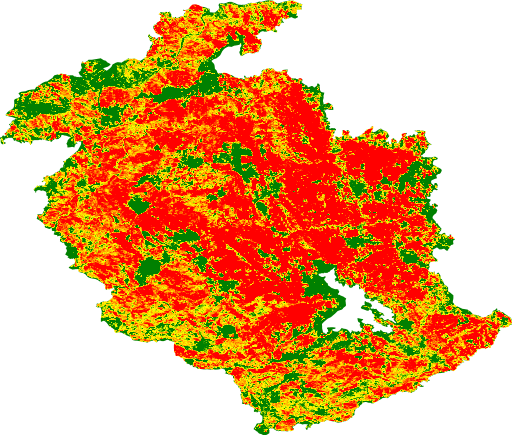

In [26]:
from IPython.display import Image, display, HTML

ftr = fire17_1_sn_ypmc.first();

timeWindow = 16*3;
gridmet_timeWindow = 4;
resample_method = 'none';
sats = ['4', '5', '7', '8'];

RBR_viz = {'bands': 'rbr', 'min': 0.041191844, 'max': 0.2836425, 'palette': '008000, ffff00, ffA500, ff0000'};

# Test merge_collections function
# firePerim = ftr.geometry();
# fireDate = ee.Date(ftr.get('alarm_date'));
# preend = fireDate.advance(-1, 'day');
# prestart = preend.advance(timeWindow * -1, 'day');

# preFireCollection = merge_collections(prestart, preend, firePerim, sats);


# Test the Raw functions
# pre = get_preFireRaw_median(ftr, timeWindow, resample_method, sats).clip(ftr);
# post = get_postFireRaw_median(ftr, timeWindow, resample_method, sats).clip(ftr);

# thumburl_pre = pre.getThumbUrl({'bands': 'B3_pre, B2_pre, B1_pre', 'min': 0, 'max': 2000});

# thumburl_post = post.getThumbUrl({'bands': 'B3_post, B2_post, B1_post', 'min': 0, 'max': 2000});

# img_thumb_pre = Image(url = thumburl_pre, embed = True, format = 'png');
# display(img_thumb_pre);

# img_thumb_post = Image(url = thumburl_post, embed = True, format = 'png');
# display(img_thumb_post);

# Test the NDVI functions
# pre = get_preFndvi(ftr, timeWindow, resample_method, sats).clip(ftr);
# post = get_postFndvi(ftr, timeWindow, resample_method, sats).clip(ftr);

# thumburl_pre = pre.getThumbUrl({'bands': 'ndvi', 'min': 0, 'max': 0.8});

# thumburl_post = post.getThumbUrl({'bands': 'ndvi', 'min': 0, 'max': 0.8});

# img_thumb_pre = Image(url = thumburl_pre, embed = True, format = 'png');
# display(img_thumb_pre);

# img_thumb_post = Image(url = thumburl_post, embed = True, format = 'png');
# display(img_thumb_post);

# # Test the NDMI functions
# pre = get_preFndmi(ftr, timeWindow, resample_method, sats).clip(ftr);
# post = get_postFndmi(ftr, timeWindow, resample_method, sats).clip(ftr);

# thumburl_pre = pre.getThumbUrl({'bands': 'ndmi', 'min': 0, 'max': 0.8});

# thumburl_post = post.getThumbUrl({'bands': 'ndmi', 'min': 0, 'max': 0.8});

# img_thumb_pre = Image(url = thumburl_pre, embed = True, format = 'png');
# display(img_thumb_pre);

# img_thumb_post = Image(url = thumburl_post, embed = True, format = 'png');
# display(img_thumb_post);

# # Test the NBR functions
# pre = get_preFnbr(ftr, timeWindow, resample_method, sats).clip(ftr);
# post = get_postFnbr(ftr, timeWindow, resample_method, sats).clip(ftr);

# thumburl_pre = pre.getThumbUrl({'bands': 'nbr', 'min': 0, 'max': 0.8});

# thumburl_post = post.getThumbUrl({'bands': 'nbr', 'min': 0, 'max': 0.8});

# img_thumb_pre = Image(url = thumburl_pre, embed = True, format = 'png');
# display(img_thumb_pre);

# img_thumb_post = Image(url = thumburl_post, embed = True, format = 'png');
# display(img_thumb_post);

# # Test the dNBR and RdNBR functions
# dnbr = get_dNBR(ftr, timeWindow, resample_method, sats).clip(ftr);
# rdnbr = get_RdNBR(ftr, timeWindow, resample_method, sats).clip(ftr);

# thumburl_dnbr = dnbr.getThumbUrl({'bands': 'dnbr', 'min': 0, 'max': 0.8});

# thumburl_rdnbr = rdnbr.getThumbUrl({'bands': 'rdnbr', 'min': 0, 'max': 30});

# img_thumb_dnbr = Image(url = thumburl_dnbr, embed = True, format = 'png');
# display(img_thumb_dnbr);

# img_thumb_rdnbr = Image(url = thumburl_rdnbr, embed = True, format = 'png');
# display(img_thumb_rdnbr);

# # Test the dNDVI and RdNDVI functions
# dndvi = get_dNDVI(ftr, timeWindow, resample_method, sats).clip(ftr);
# rdndvi = get_RdNDVI(ftr, timeWindow, resample_method, sats).clip(ftr);

# thumburl_dndvi = dndvi.getThumbUrl({'bands': 'dndvi', 'min': 0, 'max': 0.8});

# thumburl_rdndvi = rdndvi.getThumbUrl({'bands': 'rdndvi', 'min': 0, 'max': 30});

# img_thumb_dndvi = Image(url = thumburl_dndvi, embed = True, format = 'png');
# display(img_thumb_dndvi);

# img_thumb_rdndvi = Image(url = thumburl_rdndvi, embed = True, format = 'png');
# display(img_thumb_rdndvi);

# # Test the RBR function
# rbr = get_RBR(ftr, timeWindow, resample_method, sats).clip(ftr);

# thumburl_rbr = rbr.getThumbUrl(RBR_viz);

# img_thumb_rbr = Image(url = thumburl_rbr, embed = True, format = 'png');
# display(img_thumb_rbr);

# # Test the get_het_ndvi function
# pixel_radius = '1'
# het = get_hetNDVI(ftr, pixel_radius, timeWindow, resample_method, sats).clip(ftr);

# thumburl_het = het.getThumbUrl({'min': 0, 'max': 1});

# img_thumb_het = Image(url = thumburl_het, embed = True, format = 'png');
# display(img_thumb_het);

# # Test the get_neighborhood_mean_NDVI function

# pixel_radius = '1'
# nbhd_mean = get_neighborhood_mean_NDVI(ftr, pixel_radius, timeWindow, resample_method, sats).clip(ftr);

# thumburl_nbhd_mean = het.getThumbUrl({'min': -0.5, 'max': 0.5});

# img_thumb_nbhd_mean = Image(url = thumburl_nbhd_mean, embed = True, format = 'png');
# display(img_thumb_nbhd_mean);

# # Test the slope, aspect, and topographic roughness functions

# pixel_radius = '1'
# slope = get_slope(ftr).clip(ftr);
# aspect = get_aspect(ftr).clip(ftr);
# rough = get_roughness(ftr, pixel_radius, resample_method).clip(ftr);

# thumburl_slope = slope.getThumbUrl({'min': 0, 'max': 45});
# thumburl_aspect = aspect.getThumbUrl({'min': 0, 'max': 360});
# thumburl_rough = rough.getThumbUrl({'min': 0, 'max': 50});

# img_thumb_slope = Image(url = thumburl_slope, embed = True, format = 'png');
# img_thumb_aspect = Image(url = thumburl_aspect, embed = True, format = 'png');
# img_thumb_rough = Image(url = thumburl_rough, embed = True, format = 'png');

# display(img_thumb_slope);
# display(img_thumb_aspect);
# display(img_thumb_rough);

# # Test the regional climate conditions functions

# weather = get_preFerc(ftr, gridmet_timeWindow, resample_method).clip(ftr);
# thumburl_weather = weather.getThumbUrl({'min': 0, 'max': 100});
# img_thumb_weather = Image(url = thumburl_weather, embed = True, format = 'png');
# display(img_thumb_weather);

# weather = get_preFfm100(ftr, gridmet_timeWindow, resample_method).clip(ftr);
# thumburl_weather = weather.getThumbUrl({'min': 0, 'max': 10});
# img_thumb_weather = Image(url = thumburl_weather, embed = True, format = 'png');
# display(img_thumb_weather);

# weather = get_preFtmmx(ftr, gridmet_timeWindow, resample_method).clip(ftr);
# thumburl_weather = weather.getThumbUrl({'min': 0, 'max': 40});
# img_thumb_weather = Image(url = thumburl_weather, embed = True, format = 'png');
# display(img_thumb_weather);

# weather = get_preFvpd(ftr, gridmet_timeWindow, resample_method).clip(ftr);
# thumburl_weather = weather.getThumbUrl({'min': 0, 'max': 5});
# img_thumb_weather = Image(url = thumburl_weather, embed = True, format = 'png');
# display(img_thumb_weather);

# weather = get_earlyFvs(ftr, gridmet_timeWindow, resample_method).clip(ftr);
# thumburl_weather = weather.getThumbUrl({'min': 0, 'max': 10});
# img_thumb_weather = Image(url = thumburl_weather, embed = True, format = 'png');
# display(img_thumb_weather);

# weather = get_earlyFhdw(ftr, gridmet_timeWindow, resample_method).clip(ftr);
# thumburl_weather = weather.getThumbUrl({'min': 0, 'max': 10});
# img_thumb_weather = Image(url = thumburl_weather, embed = True, format = 'png');
# display(img_thumb_weather);

# Test get_variable() function
img = get_variables(ftr, timeWindow, resample_method, sats).clip(ftr);
thumburl = img.getThumbUrl(RBR_viz);
img_thumb = Image(url = thumburl, embed = True, format = 'png');
display(img_thumb);

In [97]:
def assess_whole_fire(timeWindow, resample_method, sats):
  
    def assess_whole_fire_internal(feature):
        geo = feature.geometry();
        var_img = get_variables(feature, timeWindow, resample_method, sats);
  
        export_img = ee.Algorithms.If(var_img, 
                                      ee.Image(var_img).clip(geo).copyProperties(feature), 
                                      None);

        return ee.Image(export_img);
    
    return assess_whole_fire_internal;
    

In [ ]:
# Create an Image Collection of all of the calculated variables across the FRAP FeatureCollection
# all_fire_assessments = fire17_1_sn_ypmc.map(assess_whole_fire(timeWindow, resample_method, sats), True);

# earlier_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.lt('alarm_date', ee.Date('2005-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);
# # print(earlier_fire_assessments.size().getInfo());
# Earlier than 2005: 581
# Earlier than 1995: 288

# later_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.gte('alarm_date', ee.Date('2005-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);
# # print(later_fire_assessments.size().getInfo());
# # 509

# Features with alarm dates before 1985-01-01
batch01_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.lt('alarm_date', ee.Date('1985-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);

# Features with alarm dates later than or equal to 1985-01-01, but less than 1990-01-01
batch02_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.lt('alarm_date', ee.Date('1990-01-01').millis())).filter(ee.Filter.gte('alarm_date', ee.Date('1985-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);

# Features with alarm dates later than or equal to 1990-01-01, but less than 1995-01-01
batch03_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.lt('alarm_date', ee.Date('1995-01-01').millis())).filter(ee.Filter.gte('alarm_date', ee.Date('1990-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);

# Features with alarm dates later than or equal to 1995-01-01, but less than 2000-01-01
batch04_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.lt('alarm_date', ee.Date('2000-01-01').millis())).filter(ee.Filter.gte('alarm_date', ee.Date('1995-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);

# Features with alarm dates later than or equal to 2000-01-01, but less than 2005-01-01
batch05_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.lt('alarm_date', ee.Date('2005-01-01').millis())).filter(ee.Filter.gte('alarm_date', ee.Date('2000-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);

# Features with alarm dates later than or equal to 2005-01-01, but less than 2010-01-01
batch06_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.lt('alarm_date', ee.Date('2010-01-01').millis())).filter(ee.Filter.gte('alarm_date', ee.Date('2005-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);

# Features with alarm dates later than or equal to 2010-01-01, but less than 2015-01-01
batch07_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.lt('alarm_date', ee.Date('2015-01-01').millis())).filter(ee.Filter.gte('alarm_date', ee.Date('2010-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);

# Features with alarm dates later than or equal to 2015-01-01
batch08_fire_assessments = fire17_1_sn_ypmc.filter(ee.Filter.gte('alarm_date', ee.Date('2015-01-01').millis())).map(assess_whole_fire(timeWindow, resample_method, sats), True);


In [ ]:
# loop through all images and create a feature representing the image number and acquisition date
# Export each image upon looping

num_imgs_batch1 = earlier_fire_assessments.size().getInfo();
num_imgs_batch2 = later_fire_assessments.size().getInfo();
batch1_list = earlier_fire_assessments.toList(num_imgs_batch1);

# Loop through all images, add the date to the appropriate list element, and export image
for i in range(342, num_imgs_batch1):
    img = ee.Image(batch1_list.get(i)).float();
    date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
    id = img.get('system:index');

    fileNamePrefix = str(date.getInfo()) + "_" + str(i + 1).zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

    ee.batch.Export.image.toDrive(**{
            'image': img,
            'description': fileNamePrefix,
            'fileNamePrefix': fileNamePrefix, 
            'folder': 'ee/frap-derived-fire-imagery', 
            'scale': 30,
            'crs': 'EPSG:3310'
        }).start()
    
    print(str(i + 1) + " of " + str(num_imgs_batch1 + num_imgs_batch2) + " submitted to Google for processing.")
    

batch2_list = later_fire_assessments.toList(num_imgs_batch2);

# Loop through all images, add the date to the appropriate list element, and export image
for i in range(0, num_imgs_batch2):
    img = ee.Image(batch2_list.get(i)).float();
    date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
    id = img.get('system:index');

    fileNamePrefix = str(date.getInfo()) + "_" + str(i + 1 + num_imgs_batch1).zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

    ee.batch.Export.image.toDrive(**{
            'image': img,
            'description': fileNamePrefix,
            'fileNamePrefix': fileNamePrefix, 
            'folder': 'ee/frap-derived-fire-imagery', 
            'scale': 30,
            'crs': 'EPSG:3310'
        }).start()
    
    print(str(i + 1 + num_imgs_batch1) + " of " + str(num_imgs_batch1 + num_imgs_batch2) + " submitted to Google for processing.")

# num_imgs_batch01 = batch01_fire_assessments.size().getInfo();
# num_imgs_batch02 = batch02_fire_assessments.size().getInfo();
# num_imgs_batch03 = batch03_fire_assessments.size().getInfo();
# num_imgs_batch04 = batch04_fire_assessments.size().getInfo();
# num_imgs_batch05 = batch05_fire_assessments.size().getInfo();
# num_imgs_batch06 = batch06_fire_assessments.size().getInfo();
# num_imgs_batch07 = batch07_fire_assessments.size().getInfo();
# num_imgs_batch08 = batch08_fire_assessments.size().getInfo();

# num_imgs_thru_batch02 = num_imgs_batch01 + num_imgs_batch02
# num_imgs_thru_batch03 = num_imgs_batch01 + num_imgs_batch02 + num_imgs_batch03
# num_imgs_thru_batch04 = num_imgs_batch01 + num_imgs_batch02 + num_imgs_batch03 + num_imgs_batch04
# num_imgs_thru_batch05 = num_imgs_batch01 + num_imgs_batch02 + num_imgs_batch03 + num_imgs_batch04 + num_imgs_batch05
# num_imgs_thru_batch06 = num_imgs_batch01 + num_imgs_batch02 + num_imgs_batch03 + num_imgs_batch04 + num_imgs_batch05 + num_imgs_batch06
# num_imgs_thru_batch07 = num_imgs_batch01 + num_imgs_batch02 + num_imgs_batch03 + num_imgs_batch04 + num_imgs_batch05 + num_imgs_batch06 + num_imgs_batch_07
# total_num_imgs = num_imgs_batch01 + num_imgs_batch02 + num_imgs_batch03 + num_imgs_batch04 + num_imgs_batch05 + num_imgs_batch06 + num_imgs_batch07 + num_imgs_batch08

# batch01_list = batch01_fire_assessments.toList(num_imgs_batch01);
# batch02_list = batch02_fire_assessments.toList(num_imgs_batch02);
# batch03_list = batch03_fire_assessments.toList(num_imgs_batch03);
# batch04_list = batch04_fire_assessments.toList(num_imgs_batch04);
# batch05_list = batch05_fire_assessments.toList(num_imgs_batch05);
# batch06_list = batch06_fire_assessments.toList(num_imgs_batch06);
# batch07_list = batch07_fire_assessments.toList(num_imgs_batch07);
# batch08_list = batch08_fire_assessments.toList(num_imgs_batch08);


# # Batch 1 Loop
# # Loop through all images, add the date to the appropriate list element, and export image
# for i in range(0, num_imgs_batch01):
#     img = ee.Image(batch01_list.get(i)).float();
#     date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
#     id = img.get('system:index');
#     overall_i = str(i + 1)
    
#     fileNamePrefix = str(date.getInfo()) + "_" + overall_i.zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

#     ee.batch.Export.image.toDrive(**{
#             'image': img,
#             'description': fileNamePrefix,
#             'fileNamePrefix': fileNamePrefix, 
#             'folder': 'ee/frap-derived-fire-imagery', 
#             'scale': 30,
#             'crs': 'EPSG:3310'
#         }).start()
    
#     print(overall_i + " of " + str(num_imgs) + " submitted to Google for processing.")


# # Batch 2 Loop
# # Loop through all images, add the date to the appropriate list element, and export image
# for i in range(0, num_imgs_batch02):
#     img = ee.Image(batch02_list.get(i)).float();
#     date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
#     id = img.get('system:index');
#     overall_i = str(i + 1 + num_imgs_batch01)
    
#     fileNamePrefix = str(date.getInfo()) + "_" + overall_i.zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

#     ee.batch.Export.image.toDrive(**{
#             'image': img,
#             'description': fileNamePrefix,
#             'fileNamePrefix': fileNamePrefix, 
#             'folder': 'ee/frap-derived-fire-imagery', 
#             'scale': 30,
#             'crs': 'EPSG:3310'
#         }).start()
    
#     print(overall_i + " of " + str(num_imgs) + " submitted to Google for processing.")

# # Batch 3 Loop
# # Loop through all images, add the date to the appropriate list element, and export image
# for i in range(0, num_imgs_batch03):
#     img = ee.Image(batch03_list.get(i)).float();
#     date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
#     id = img.get('system:index');
#     overall_i = str(i + 1 + num_imgs_thru_batch02)
    
#     fileNamePrefix = str(date.getInfo()) + "_" + overall_i.zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

#     ee.batch.Export.image.toDrive(**{
#             'image': img,
#             'description': fileNamePrefix,
#             'fileNamePrefix': fileNamePrefix, 
#             'folder': 'ee/frap-derived-fire-imagery', 
#             'scale': 30,
#             'crs': 'EPSG:3310'
#         }).start()
    
#     print(overall_i + " of " + str(num_imgs) + " submitted to Google for processing.")

# # Batch 4 Loop
# # Loop through all images, add the date to the appropriate list element, and export image
# for i in range(0, num_imgs_batch04):
#     img = ee.Image(batch04_list.get(i)).float();
#     date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
#     id = img.get('system:index');
#     overall_i = str(i + 1 + num_imgs_thru_batch03)
    
#     fileNamePrefix = str(date.getInfo()) + "_" + overall_i.zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

#     ee.batch.Export.image.toDrive(**{
#             'image': img,
#             'description': fileNamePrefix,
#             'fileNamePrefix': fileNamePrefix, 
#             'folder': 'ee/frap-derived-fire-imagery', 
#             'scale': 30,
#             'crs': 'EPSG:3310'
#         }).start()
    
#     print(overall_i + " of " + str(num_imgs) + " submitted to Google for processing.")

# # Batch 5 Loop
# # Loop through all images, add the date to the appropriate list element, and export image
# for i in range(0, num_imgs_batch05):
#     img = ee.Image(batch05_list.get(i)).float();
#     date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
#     id = img.get('system:index');
#     overall_i = str(i + 1 + num_imgs_thru_batch04)
    
#     fileNamePrefix = str(date.getInfo()) + "_" + overall_i.zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

#     ee.batch.Export.image.toDrive(**{
#             'image': img,
#             'description': fileNamePrefix,
#             'fileNamePrefix': fileNamePrefix, 
#             'folder': 'ee/frap-derived-fire-imagery', 
#             'scale': 30,
#             'crs': 'EPSG:3310'
#         }).start()
    
#     print(overall_i + " of " + str(num_imgs) + " submitted to Google for processing.")
    
# # Batch 6 Loop
# # Loop through all images, add the date to the appropriate list element, and export image
# for i in range(0, num_imgs_batch06):
#     img = ee.Image(batch06_list.get(i)).float();
#     date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
#     id = img.get('system:index');
#     overall_i = str(i + 1 + num_imgs_thru_batch05)
    
#     fileNamePrefix = str(date.getInfo()) + "_" + overall_i.zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

#     ee.batch.Export.image.toDrive(**{
#             'image': img,
#             'description': fileNamePrefix,
#             'fileNamePrefix': fileNamePrefix, 
#             'folder': 'ee/frap-derived-fire-imagery', 
#             'scale': 30,
#             'crs': 'EPSG:3310'
#         }).start()
    
#     print(overall_i + " of " + str(num_imgs) + " submitted to Google for processing.")
    
# # Batch 7 Loop
# # Loop through all images, add the date to the appropriate list element, and export image
# for i in range(0, num_imgs_batch07):
#     img = ee.Image(batch07_list.get(i)).float();
#     date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
#     id = img.get('system:index');
#     overall_i = str(i + 1 + num_imgs_thru_batch06)
    
#     fileNamePrefix = str(date.getInfo()) + "_" + overall_i.zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

#     ee.batch.Export.image.toDrive(**{
#             'image': img,
#             'description': fileNamePrefix,
#             'fileNamePrefix': fileNamePrefix, 
#             'folder': 'ee/frap-derived-fire-imagery', 
#             'scale': 30,
#             'crs': 'EPSG:3310'
#         }).start()
    
#     print(overall_i + " of " + str(num_imgs) + " submitted to Google for processing.")
    
# # Batch 8 Loop
# # Loop through all images, add the date to the appropriate list element, and export image
# for i in range(0, num_imgs_batch08):
#     img = ee.Image(batch08_list.get(i)).float();
#     date = ee.Date(img.get('alarm_date')).format("YYYYMMdd");
#     id = img.get('system:index');
#     overall_i = str(i + 1 + num_imgs_thru_batch07)
    
#     fileNamePrefix = str(date.getInfo()) + "_" + overall_i.zfill(5) + "_" + str(id.getInfo()) + "_epsg3310"

#     ee.batch.Export.image.toDrive(**{
#             'image': img,
#             'description': fileNamePrefix,
#             'fileNamePrefix': fileNamePrefix, 
#             'folder': 'ee/frap-derived-fire-imagery', 
#             'scale': 30,
#             'crs': 'EPSG:3310'
#         }).start()
    
#     print(overall_i + " of " + str(num_imgs) + " submitted to Google for processing.")

343 of 1090 submitted to Google for processing.
344 of 1090 submitted to Google for processing.
345 of 1090 submitted to Google for processing.
346 of 1090 submitted to Google for processing.
347 of 1090 submitted to Google for processing.
348 of 1090 submitted to Google for processing.
349 of 1090 submitted to Google for processing.
350 of 1090 submitted to Google for processing.
351 of 1090 submitted to Google for processing.
352 of 1090 submitted to Google for processing.
353 of 1090 submitted to Google for processing.
354 of 1090 submitted to Google for processing.
355 of 1090 submitted to Google for processing.
356 of 1090 submitted to Google for processing.
357 of 1090 submitted to Google for processing.
358 of 1090 submitted to Google for processing.
359 of 1090 submitted to Google for processing.
360 of 1090 submitted to Google for processing.
361 of 1090 submitted to Google for processing.
362 of 1090 submitted to Google for processing.
363 of 1090 submitted to Google for proc